In [1]:
import cobra
import thermo_flux
from thermo_flux.core.model import ThermoModel, ThermoReaction
from equilibrator_api import  Q_

import pandas as pd

In [2]:
from cobra.core import Metabolite, Reaction
from thermo_flux.core.model import ThermoMetabolite, ThermoReaction

In [3]:
# !pip install cvxpy

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

def plot_reaction(drGmprime_df, reactions_list):
    # Get the reaction names and drGmprime values
    reactions = drGmprime_df['reaction'].values
    drGmprime = drGmprime_df['drGmprime'].values
    errors = drGmprime_df['drG_SE'].values

    # Filter the reactions based on the provided list
    filtered_reactions = [reaction for reaction in reactions if reaction in reactions_list]
    filtered_drGmprime = [drGmprime[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]
    filtered_errors = [errors[i] for i, reaction in enumerate(reactions) if reaction in reactions_list]

    # Plot the filtered drGmprime values with error bars
    plt.errorbar(filtered_reactions, filtered_drGmprime, yerr=filtered_errors, fmt='o')

    # Set the x-axis label
    plt.xlabel('Reaction')

    # Set the y-axis label
    plt.ylabel('drGmprime')

    # Set the title
    plt.title('drGmprime vs. Reaction')

    # Tilt the x-axis labels by 270 degrees
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()


In [6]:
def calc_drG_bounds_kcal(thermo_flux_model, units = "kcal/mol"):
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)

    if units == "kcal/mol":
        bounds_df = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    return bounds_df

In [7]:
import matplotlib.pyplot as plt

def plot_reaction_bounds(bounds_df, reactions_list):
    # Get the reaction names and drGmprime values
    reactions = bounds_df.index.tolist()

    bound_values = bounds_df_kcal.values.tolist()
    
    # plot lb and ub for each reaction
    for rxn in reactions:
        if rxn in reactions_list:
            lb = bounds_df.T[rxn].tolist()[0]
            ub  = bounds_df.T[rxn].tolist()[1]

            plt.plot((rxn,rxn),(lb, ub),c='blue', marker="o")
    
    plt.axhline(0, color='red', linewidth=2)  # Add a thick red line at y=0
    plt.xlabel('reaction ID')
    plt.ylabel('bounds')


    # # Tilt the x-axis labels by 270 degrees
    plt.xticks(rotation=90)

    # # Show the plot
    plt.show()


In [8]:
import matplotlib.pyplot as plt

def plot_dataframe_values(index_names, dataframe):
    for name in index_names:
        x = dataframe.columns.values

        y_lb = []
        y_ub = []

        for value in range(len(x)):
            y_lb.append(dataframe.loc[name].values[value][0])
            y_ub.append(dataframe.loc[name].values[value][1])

        plt.scatter(x, y_lb, label="lb", color='blue')
        plt.scatter(x, y_ub, label="ub", color='blue')
        plt.fill_between(x, y_lb, y_ub, color='blue', alpha=0.3)

        plt.axhline(0, color='red', linewidth=2)  # Add a thick red line at y=0

        plt.xlabel('Ratios')
        plt.ylabel('drG')
        plt.title(name)
        # plt.legend()
        plt.show()


In [12]:
# prettier plots
import matplotlib.pyplot as plt

def plot_dataframe_values(index_names, dataframe):
    for name in index_names:
        x = dataframe.columns.values

        y_lb = []
        y_ub = []

        for value in range(len(x)):
            y_lb.append(dataframe.loc[name].values[value][0])
            y_ub.append(dataframe.loc[name].values[value][1])

        plt.scatter(x, y_lb, label="lb", color='blue')
        plt.scatter(x, y_ub, label="ub", color='blue')
        plt.fill_between(x, y_lb, y_ub, color='blue', alpha=0.3)

        plt.axhline(0, color='red', linewidth=2)  # Add a thick red line at y=0

        # Set larger font sizes
        plt.xlabel('Ratios', fontsize=14)
        plt.ylabel('drG', fontsize=14)
        plt.title(name, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size

        # plt.legend()
        plt.show()

In [13]:
import pandas as pd

def calculate_flux_bounds(tmodel, ratio_list, metabolite):
    """
    Calculate flux bounds for different ratios using the provided model.

    Args:
        tmodel (object): The model object.
        ratio_list (list): List of ratios to iterate over.

    Returns:
        pandas.DataFrame: DataFrame containing the flux bounds for each ratio.
    """
    compiled_df = pd.DataFrame()

    for item in ratio_list:
        try:
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
        except:
            tmodel.metabolites.get_by_id(metabolite).upper_bound = Q_(item, 'mM')
            tmodel.metabolites.get_by_id(metabolite).lower_bound = Q_(item, 'mM')

        tmodel.m = None  # reset the gurobi model object in case you're re-running this cell 
        tmodel.add_TFBA_variables(gdiss_constraint=False, qnorm=1, error_type='covariance')
        bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)

        # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
        compiled_df.insert(0, str(item) + "_ub", bounds_df.ub, False)
        compiled_df.insert(0, str(item) + "_lb", bounds_df.lb, False)

    new_compiled_df = pd.DataFrame()
    new_compiled_df.index = compiled_df.index

    for value in ratio_list:
        new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

    return new_compiled_df


# CETCH cycle

In [14]:
model = cobra.io.read_sbml_model(r"CETCH_cycle_exchange.xml")
model.objective = model.reactions.MALSYN_RXN
sol = model.optimize()
model.summary(sol)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Set parameter Username


CobraSBMLError: Something went wrong reading the SBML model. Most likely the SBML model is not valid. Please check that your model is valid using the `cobra.io.sbml.validate_sbml_model` function or via the online validator at https://sbml.org/validator_servlet/ .
	`(model, errors) = validate_sbml_model(filename)`
If the model is valid and cannot be read please open an issue at https://github.com/opencobra/cobrapy/issues .

In [ ]:
tmodel = ThermoModel(model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [ ]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3),
    'u': Q_(7.0)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [ ]:
for met in tmodel.metabolites:
    met_cmp= met.annotation["biocyc"].replace("META:","")
    met.annotation = {"metacyc.compound":met_cmp}

    if " " in met.annotation["metacyc.compound"]:
        met.annotation["metacyc.compound"] = met.annotation["metacyc.compound"].replace(" ","")
    

In [ ]:
for met in tmodel.metabolites:
    print(met.annotation)

{'metacyc.compound': 'GLYOX'}
{'metacyc.compound': 'WATER'}
{'metacyc.compound': 'ACETYL-COA'}
{'metacyc.compound': 'PROTON'}
{'metacyc.compound': 'MAL'}
{'metacyc.compound': 'CO-A'}
{'metacyc.compound': 'ATP'}
{'metacyc.compound': '4-HYDROXY-BUTYRATE'}
{'metacyc.compound': '4-HYDROXY-BUTYRYL-COA'}
{'metacyc.compound': 'ADP'}
{'metacyc.compound': 'Pi'}
{'metacyc.compound': 'NADP'}
{'metacyc.compound': 'NADPH'}
{'metacyc.compound': 'SUCC-S-ALD'}
{'metacyc.compound': 'OXYGEN-MOLECULE'}
{'metacyc.compound': 'CPD-9407'}
{'metacyc.compound': 'CPD-9408'}
{'metacyc.compound': 'HYDROGEN-PEROXIDE'}
{'metacyc.compound': 'PROPIONYL-COA'}
{'metacyc.compound': 'ACRYLYL-COA'}
{'metacyc.compound': 'CPD-9406'}
{'metacyc.compound': 'CROTONYL-COA'}
{'metacyc.compound': 'CARBON-DIOXIDE'}
{'metacyc.compound': 'CPD-17635'}
{'metacyc.compound': 'CPD-9409'}
{'metacyc.compound': 'METHYL-MALONYL-COA'}
{'metacyc.compound': 'SUC-COA'}
{'metacyc.compound': 'CPD-226'}


In [ ]:
thermo_flux.tools.drg_tools.get_suitable_ids(tmodel.metabolites.GLYOX)

Initilizing component contribution object...


No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from _compound.sqlite


(Compound(id=66, inchi_key=HHLFWLYXYJOTON-UHFFFAOYSA-M), {}, None, None, False)

In [ ]:
thermo_flux.tools.drg_tools.calc_dfG_transform(tmodel.metabolites.ACETYL_COA)

1371.8122671936244 <Unit('kilojoule / mole')>

In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

[████████████████████████████████████████] 28/28 CPD_226                              



[]

In [ ]:
#concentration data all in mM 
ConcLimits_df = pd.read_excel('cetch_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'mM')
            met.lower_bound = Q_(lb,'mM')
            print(met.id)

GLYOX
WATER
ACETYL_COA
MAL
CO_A
ATP
4_HYDROXY_BUTYRATE
4_HYDROXY_BUTYRYL_COA
ADP
Pi
NADP
NADPH
SUCC_S_ALD
OXYGEN_MOLECULE
CPD_9407
CPD_9408
HYDROGEN_PEROXIDE
PROPIONYL_COA
ACRYLYL_COA
CPD_9406
CROTONYL_COA
CARBON_DIOXIDE
CPD_17635
CPD_9409
METHYL_MALONYL_COA
SUC_COA
CPD_226


In [ ]:
tmodel.metabolites.GLYOX.upper_bound

20.0 <Unit('millimolar')>

In [ ]:
tmodel.metabolites.GLYOX.lower_bound

0.01 <Unit('millimolar')>

In [ ]:
thermo_flux.tools.drg_tools.get_compound(tmodel.metabolites.WATER)

Compound(id=5, inchi_key=XLYOFNOQVPJJNP-UHFFFAOYSA-N)

In [ ]:
# for met in tmodel.metabolites:
#     try:
#         met.lower_bound = Q_(1,'mM')
#         met.upper_bound = Q_(1,'mM')
#     except:
#         met.upper_bound = Q_(1,'mM')
#         met.lower_bound = Q_(1,'mM')

In [ ]:
tmodel.metabolites.GLYOX.concentration

1 <Unit('molar')>

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 28/28 CPD_226                              

Estimating dfG0'...
[████████████████████████████████████████] 30/30 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [ ]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [ ]:
bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95) 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
tmodel._rmse_inf

3000 <Unit('kilojoule / mole')>

In [ ]:
for rxn in tmodel.reactions:
    print(rxn.id, "\t", rxn.drG_SE)

MALSYN_RXN 	 2.081758617438947 kilojoule / mole
RXN_8961 	 3.0140600870424894 kilojoule / mole
RXN_15977 	 5.308282697132137 kilojoule / mole
RXN_18384 	 4.380841802160132 kilojoule / mole
METHYLMALONYL_COA_MUT_RXN 	 2.073145691421793 kilojoule / mole
RXN_8891 	 2.741059699994797 kilojoule / mole
RXN_11002 	 1.7074524659665746 kilojoule / mole
RXN_18387 	 1.8761154422533108 kilojoule / mole
RXN_8890 	 2.4371689046283436 kilojoule / mole
RXN_8957 	 3.993568120529032 kilojoule / mole
RXN_16391 	 3.697785493223493e-32 kilojoule / mole
RXN_8958 	 4.529975766397789e-16 kilojoule / mole
RXN_18381 	 4.48987935776239 kilojoule / mole
RXN_8960 	 1.9030338036478547 kilojoule / mole
MAL_tx 	 0.9873559681976731 kilojoule / mole
CO2_tx 	 2.9318707535840742 kilojoule / mole
ACETYL_COA_tx 	 7.826810198529089 kilojoule / mole
ATP_tx 	 1.4899855434834717 kilojoule / mole
ADP_tx 	 1.225790908474294 kilojoule / mole
NADPH_tx 	 6.829013246048599 kilojoule / mole
NADP_tx 	 6.831885021911919 kilojoule / mol

In [ ]:
for rxn in tmodel.reactions:
    print(rxn.id, "\t", rxn.drG_SE.to('kcal/mol'))

MALSYN_RXN 	 0.497552250821928 kilocalorie / mole
RXN_8961 	 0.7203776498667517 kilocalorie / mole
RXN_15977 	 1.2687100136549083 kilocalorie / mole
RXN_18384 	 1.0470463198279474 kilocalorie / mole
METHYLMALONYL_COA_MUT_RXN 	 0.49549371209889886 kilocalorie / mole
RXN_8891 	 0.6551289913945499 kilocalorie / mole
RXN_11002 	 0.40809093354841647 kilocalorie / mole
RXN_18387 	 0.4484023523549978 kilocalorie / mole
RXN_8890 	 0.5824973481425295 kilocalorie / mole
RXN_8957 	 0.9544856884629617 kilocalorie / mole
RXN_16391 	 8.83791943887068e-33 kilocalorie / mole
RXN_8958 	 1.0826901927336972e-16 kilocalorie / mole
RXN_18381 	 1.0731069210713169 kilocalorie / mole
RXN_8960 	 0.4548359951357205 kilocalorie / mole
MAL_tx 	 0.23598374000900407 kilocalorie / mole
CO2_tx 	 0.700733927720859 kilocalorie / mole
ACETYL_COA_tx 	 1.8706525331092467 kilocalorie / mole
ATP_tx 	 0.3561150916547494 kilocalorie / mole
ADP_tx 	 0.2929710584307586 kilocalorie / mole
NADPH_tx 	 1.6321733379657262 kilocalori

In [ ]:
for met in tmodel.metabolites:
    if met.dfG_SE >= tmodel._rmse_inf:
        print(met.id, met.dfG_SE, met.annotation)

charge_u 3000.0 kilojoule / mole {}


In [ ]:
tmodel.metabolites.CPD_9407.compound.identifiers

[CompoundIdentifier(registry=Registry(namespace=chebi), accession=CHEBI:81672),
 CompoundIdentifier(registry=Registry(namespace=chebi), accession=CHEBI:84866),
 CompoundIdentifier(registry=Registry(namespace=kegg), accession=C18324),
 CompoundIdentifier(registry=Registry(namespace=metacyc.compound), accession=CPD-9407),
 CompoundIdentifier(registry=Registry(namespace=seed), accession=cpd19589),
 CompoundIdentifier(registry=Registry(namespace=metanetx.chemical), accession=MNXM5823),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=(2S)-methylsuccinyl-CoA),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=(2S)-methylsuccinyl-coenzyme A),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=Methylsuccinyl-CoA),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=Methylsuccinyl-coenzyme A),
 CompoundIdentifier(registry=Registry(namespace=synonyms), accession=OUFHQHVVFSERRI-VKBDFPRVSA-N),
 CompoundIdentifier(registry=R

In [ ]:
tmodel.reactions[0].drG0prime

-35.811333743200976 <Unit('kilojoule / mole')>

In [ ]:
for rxn in tmodel.reactions:
    print(rxn.id, "\t", rxn.drGmprime.to('kcal/mol'), "\t", rxn.drG_SE.to('kcal/mol'))

MALSYN_RXN 	 -4.468569839502854 kilocalorie / mole 	 0.497552250821928 kilocalorie / mole
RXN_8961 	 -0.49360430183069526 kilocalorie / mole 	 0.7203776498667517 kilocalorie / mole
RXN_15977 	 -17.177014785142386 kilocalorie / mole 	 1.2687100136549083 kilocalorie / mole
RXN_18384 	 -5.669564096372622 kilocalorie / mole 	 1.0470463198279474 kilocalorie / mole
METHYLMALONYL_COA_MUT_RXN 	 -1.9965264980934827 kilocalorie / mole 	 0.49549371209889886 kilocalorie / mole
RXN_8891 	 1.4475355473939144 kilocalorie / mole 	 0.6551289913945499 kilocalorie / mole
RXN_11002 	 0.12259569656085906 kilocalorie / mole 	 0.40809093354841647 kilocalorie / mole
RXN_18387 	 -3.8912020636719005 kilocalorie / mole 	 0.4484023523549978 kilocalorie / mole
RXN_8890 	 -6.684621090455249 kilocalorie / mole 	 0.5824973481425295 kilocalorie / mole
RXN_8957 	 -5.43395753440906 kilocalorie / mole 	 0.9544856884629617 kilocalorie / mole
RXN_16391 	 3.570950243937794e-16 kilocalorie / mole 	 8.83791943887068e-33 kiloc

In [ ]:
tmodel.reactions.RXN_8961

Reaction identifier,RXN_8961
Name,malyl-CoA lyase
Memory address,0x7f6e9e878ee0
Stoichiometry,"CPD_9409 <=> GLYOX + PROPIONYL_COA (2R,3S)-β-methylmalyl-CoA <=> glyoxylate + propanoyl-CoA"
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
tmodel.reactions.MALSYN_RXN.drGmprime.m

-18.696496208479942

In [ ]:
tmodel.reactions.MALSYN_RXN.drGmprime.m_as('kcal/mol')

-4.468569839502854

In [ ]:
drGmprime_df = pd.DataFrame(columns=['reaction','drGmprime','drG_SE'])
df_list = []

for rxn in tmodel.reactions:
    data ={'reaction':rxn.id, 'drGmprime':rxn.drGmprime.m_as('kcal/mol'), 'drG_SE':rxn.drG_SE.m_as('kcal/mol')}
    df_list.append(pd.DataFrame(data, index=[0]))

drGmprime_df = pd.concat(df_list)


In [ ]:
drGmprime_df

,reaction,drGmprime,drG_SE
0,MALSYN_RXN,-4.468570e+00,4.975523e-01
0,RXN_8961,-4.936043e-01,7.203776e-01
0,RXN_15977,-1.717701e+01,1.268710e+00
0,RXN_18384,-5.669564e+00,1.047046e+00
0,METHYLMALONYL_COA_MUT_RXN,-1.996526e+00,4.954937e-01
0,RXN_8891,1.447536e+00,6.551290e-01
0,RXN_11002,1.225957e-01,4.080909e-01
0,RXN_18387,-3.891202e+00,4.484024e-01
0,RXN_8890,-6.684621e+00,5.824973e-01
0,RXN_8957,-5.433958e+00,9.544857e-01


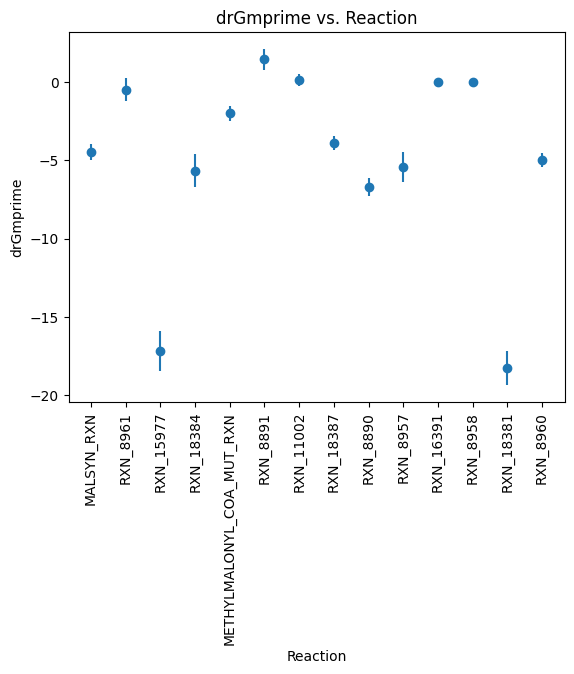

In [ ]:
rxn_list1 = [rxn.id for rxn in tmodel.reactions if not rxn.id.endswith("_tx")]

plot_reaction(drGmprime_df, rxn_list1)

In [ ]:
thermo_flux.tools.drg_tools.calc_model_drG0(tmodel)

Magnitude,[6.9588450478595405 8.67233616377598 -71.95250154839323 -38.05589005295042 -7.571646229303951 43.858767604056084 -45.98645811939059 -21.483355426267735 -10.195393016173512 -38.990656777847505 0.0 0.0 -76.4269889781367 -3.686422011659033 -841.1781113959644 -386.0000000000019 -3231.0580128140787 -2811.578331958078 -1945.4278989637223 -3070.5260288612576 -3098.931269475794 0.0 -133.98848078973268 16.399999999865035 -3091.7676959124556 -1095.2054811974629 -238.1367122055623]
Units,kilojoule/mole


In [ ]:
tmodel.reactions.MALSYN_RXN.drGmprime.to('kcal/mol')

-4.468569839502854 <Unit('kilocalorie / mole')>

In [ ]:
Q_(bounds_df.values, 'kJ/mol').to('kcal/mol')


Magnitude,[[-18.395798991981486 10.411715245564565] [-12.284151735594751 10.3438871993446] [-34.2144010313492 -0.13962853893556665] [-23.07701609601424 12.690943823564426] [-9.635741064944417 5.642688068757453] [-13.477706511268543 17.32583353864513] [-11.464056221126757 11.70924761424847] [-20.23416970346773 12.45176557612394] [-17.60190309095131 3.279604977452022] [-22.25517641129386 12.340317265911622] [-4.501003192574851 4.501003192574852] [-4.501003192574853 4.501003192574851] [-34.06498861663919 -2.46792205853337] [-15.080489507697461 4.183931197959795] [-171.1852811911933 -163.69507010783502] [-103.51188914274415 -90.13468377584984] [-463.03575717468 -434.83918363131943] [-558.2873433115467 -549.2754274518614] [-348.8506134669901 -340.6385435729209] [-501.0203278115591 -475.84457210873893] [-516.175970364074 -490.99152039561164] [3.429150821768257e-13 -3.429150821768257e-13] [-23.803476140824642 -10.426270773930403] [-7.335980920978777 6.041224445915794] [-449.1808418952209 -420.86202275546776] [-260.9679860546131 -254.20023420316483] [-45.406348434192225 -38.60737915742443]]
Units,kilocalorie/mole


In [ ]:
Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m.T[0]


array([-1.83957990e+01, -1.22841517e+01, -3.42144010e+01, -2.30770161e+01,
       -9.63574106e+00, -1.34777065e+01, -1.14640562e+01, -2.02341697e+01,
       -1.76019031e+01, -2.22551764e+01, -4.50100319e+00, -4.50100319e+00,
       -3.40649886e+01, -1.50804895e+01, -1.71185281e+02, -1.03511889e+02,
       -4.63035757e+02, -5.58287343e+02, -3.48850613e+02, -5.01020328e+02,
       -5.16175970e+02,  3.42915082e-13, -2.38034761e+01, -7.33598092e+00,
       -4.49180842e+02, -2.60967986e+02, -4.54063484e+01])

In [ ]:
bounds_df

,lb,ub
MALSYN_RXN,-7.696802e+01,4.356262e+01
RXN_8961,-5.139689e+01,4.327882e+01
RXN_15977,-1.431531e+02,-5.842058e-01
RXN_18384,-9.655424e+01,5.309891e+01
METHYLMALONYL_COA_MUT_RXN,-4.031594e+01,2.360901e+01
RXN_8891,-5.639072e+01,7.249129e+01
RXN_11002,-4.796561e+01,4.899149e+01
RXN_18387,-8.465977e+01,5.209819e+01
RXN_8890,-7.364636e+01,1.372187e+01
RXN_8957,-9.311566e+01,5.163189e+01


In [ ]:
bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m

In [ ]:
def cal_drG_bounds_kcal(thermo_flux_model, units = "kcal/mol"):
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)

    if units == "kcal/mol":
        bounds_df = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    return bounds_df

In [ ]:
bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

In [ ]:
bounds_df_kcal

,lb,ub
MALSYN_RXN,-1.839580e+01,1.041172e+01
RXN_8961,-1.228415e+01,1.034389e+01
RXN_15977,-3.421440e+01,-1.396285e-01
RXN_18384,-2.307702e+01,1.269094e+01
METHYLMALONYL_COA_MUT_RXN,-9.635741e+00,5.642688e+00
RXN_8891,-1.347771e+01,1.732583e+01
RXN_11002,-1.146406e+01,1.170925e+01
RXN_18387,-2.023417e+01,1.245177e+01
RXN_8890,-1.760190e+01,3.279605e+00
RXN_8957,-2.225518e+01,1.234032e+01


In [ ]:
index_list = []
for item in bounds_df_kcal.index:
    print(item)
    if "_tx" not in item:
        index_list.append(item)

MALSYN_RXN
RXN_8961
RXN_15977
RXN_18384
METHYLMALONYL_COA_MUT_RXN
RXN_8891
RXN_11002
RXN_18387
RXN_8890
RXN_8957
RXN_16391
RXN_8958
RXN_18381
RXN_8960
MAL_tx
CO2_tx
ACETYL_COA_tx
ATP_tx
ADP_tx
NADPH_tx
NADP_tx
PROTON_tx
HYDROGEN_PEROXIDE_tx
OXYGEN_MOLECULE_tx
CO_A_tx
Pi_tx
WATER_tx


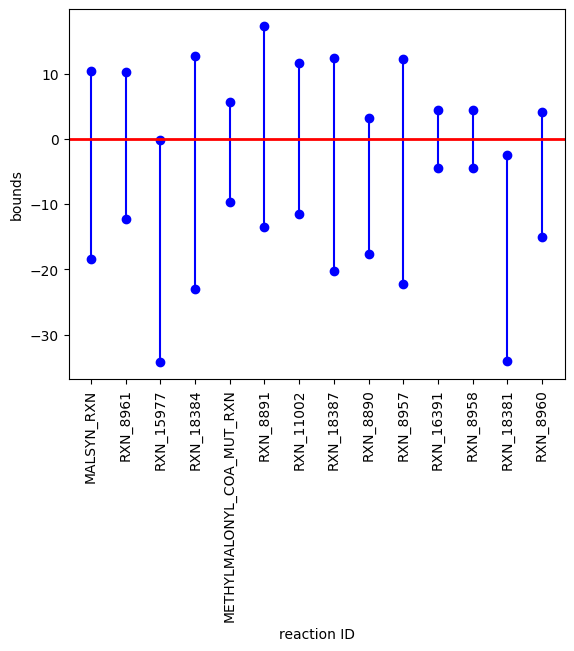

In [ ]:
rxn_list1 = [rxn.id for rxn in tmodel.reactions if not rxn.id.endswith("_tx")]

plot_reaction_bounds(bounds_df_kcal, rxn_list1)

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 30/30 Mg_u                                 

Estimating dfG0'...
[████████████████████████████████████████] 30/30 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [ ]:
ratio_list = [0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100]

tmodel.metabolites.NADP.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADP.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADPH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)


    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.01 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.2 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.4 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.6 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.8 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

2 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

3 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

4 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

5 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                                              

100 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
new_compiled_df

,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100
MALSYN_RXN,"[-76.96802298245265, 43.56261658744333]","[-76.96802298245228, 43.56261658744249]","[-76.96802298245194, 43.56261658744484]","[-76.96802298245203, 43.56261658744495]","[-76.96802298245184, 43.56261658744463]","[-76.96802298245144, 43.56261658744481]","[-76.96802298245119, 43.562616587444005]","[-76.9680229824512, 43.56261658744281]","[-76.96802298245213, 43.56261658744291]","[-76.96802298245227, 43.56261658744258]","[-76.96802298245187, 43.56261658744375]"
RXN_8961,"[-51.39689086172562, 43.27882404205479]","[-51.396890861725474, 43.27882404205424]","[-51.39689086172524, 43.27882404205418]","[-51.39689086172548, 43.27882404205402]","[-51.396890861725296, 43.27882404205411]","[-51.39689086172535, 43.27882404205407]","[-51.39689086172534, 43.27882404205397]","[-51.396890861725254, 43.27882404205387]","[-51.39689086172507, 43.27882404205418]","[-51.396890861725126, 43.27882404205401]","[-51.39689086172598, 43.278824042053984]"
RXN_15977,"[-143.15305391515346, -0.5842058069180993]","[-143.15305391515332, -0.5842058069183267]","[-143.1530539151537, -0.584205806918277]","[-143.15305391515403, -0.5842058069177511]","[-143.15305391515358, -0.5842058069182627]","[-143.15305391515358, -0.5842058069178151]","[-143.15305391515332, -0.5842058069179714]","[-143.15305391515392, -0.5842058069181135]","[-143.15305391515327, -0.5842058069181562]","[-143.1530539151538, -0.5842058069180993]","[-143.1530539151532, -0.5842058069182912]"
RXN_18384,"[-66.31214629840956, 45.676603305908614]","[-73.73445196627216, 38.25429763804544]","[-75.45181178922796, 36.53693781508841]","[-76.45640288590155, 35.53234671841673]","[-77.16917161218318, 34.81957799213515]","[-77.72203798822328, 34.26671161609606]","[-79.43939781117895, 32.549351793140005]","[-80.44398890785283, 31.5447606964665]","[-81.15675763413441, 30.83199197018489]","[-81.70962401017458, 30.27912559414459]","[-89.13192967803701, 22.85681992627976]"
METHYLMALONYL_COA_MUT_RXN,"[-40.31594061572822, 23.609006879682013]","[-40.31594061572739, 23.609006879681118]","[-40.31594061572732, 23.609006879680912]","[-40.31594061572811, 23.60900687968175]","[-40.315940615728024, 23.609006879682013]","[-40.315940615727456, 23.60900687968104]","[-40.315940615727314, 23.609006879681175]","[-40.315940615727186, 23.60900687968105]","[-40.3159406157271, 23.609006879680937]","[-40.31594061572699, 23.60900687968077]","[-40.315940615726774, 23.609006879680745]"
RXN_8891,"[-48.96841837532873, 42.24919847824481]","[-41.54611270746575, 49.6715041461071]","[-39.82875288451005, 51.388863969062925]","[-38.82416178783591, 52.393455065736894]","[-38.11139306155415, 53.10622379201827]","[-37.55852668551407, 53.65909016805846]","[-35.84116686255854, 55.376449991014155]","[-34.83657576588659, 56.38104108768816]","[-34.123807039605, 57.093809813969685]","[-33.57094066356475, 57.64667619000969]","[-26.148634995700327, 65.0689818578726]"
RXN_11002,"[-17.723522181757613, 41.56918635020695]","[-25.14582784962144, 34.14688068234549]","[-26.86318767257677, 32.429520859389484]","[-27.867778769250723, 31.424929762715273]","[-28.580547495532002, 30.71216103643377]","[-29.13341387157226, 30.159294660393485]","[-30.850773694527746, 28.441934837437728]","[-31.855364791201833, 27.4373437407635]","[-32.56813351748331, 26.724575014482078]","[-33.12099989352453, 26.171708638442897]","[-40.54330556138646, 18.749402970579823]"
RXN_18387,"[-84.65976603931128, 52.09818717050479]","[-84.65976603931261, 52.098187170505994]","[-84.6597660393126, 52.09818717050576]","[-84.65976603931227, 52.09818717050595]","[-84.65976603931128, 52.098187170504886]","[-84.6597660393113, 52.09818717050464]","[-84.65976603931135, 52.09818717050585]","[-84.65976603931227, 52.09818717050573]","[-84.6597660393124, 52.09818717050566]","[-84.65976603931229, 52.09818717050563]","[-84.65976603931186, 52.09818717050539]"
RXN_8890,"[-73.64636253253808, 13.721867225659032]","[-73.64636253254002, 13.721867225658249]","[-73.64636253254025,

In [ ]:
ratio_list = [0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100]

tmodel.metabolites.NADP.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADP.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADPH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.01 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.2 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.4 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.6 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.8 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

2 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

3 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

4 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

5 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

100 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
new_compiled_df

,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100
MALSYN_RXN,"[-18.39579899198199, 10.41171524556485]","[-18.395798991981902, 10.411715245564649]","[-18.39579899198182, 10.41171524556521]","[-18.39579899198184, 10.411715245565237]","[-18.395798991981795, 10.41171524556516]","[-18.395798991981703, 10.411715245565203]","[-18.39579899198164, 10.41171524556501]","[-18.395798991981643, 10.411715245564725]","[-18.395798991981863, 10.411715245564748]","[-18.3957989919819, 10.411715245564668]","[-18.395798991981803, 10.411715245564949]"
RXN_8961,"[-12.284151735594078, 10.343887199343877]","[-12.284151735594042, 10.343887199343747]","[-12.284151735593985, 10.343887199343733]","[-12.284151735594044, 10.343887199343694]","[-12.284151735594, 10.343887199343717]","[-12.284151735594014, 10.343887199343706]","[-12.28415173559401, 10.343887199343682]","[-12.284151735593989, 10.343887199343659]","[-12.284151735593944, 10.343887199343733]","[-12.284151735593959, 10.343887199343692]","[-12.284151735594163, 10.343887199343685]"
RXN_15977,"[-34.214401031346426, -0.13962853893836025]","[-34.21440103134639, -0.1396285389384146]","[-34.21440103134648, -0.1396285389384027]","[-34.21440103134656, -0.13962853893827704]","[-34.214401031346455, -0.1396285389383993]","[-34.214401031346455, -0.13962853893829233]","[-34.21440103134639, -0.1396285389383297]","[-34.21440103134654, -0.13962853893836363]","[-34.214401031346384, -0.13962853893837385]","[-34.21440103134651, -0.13962853893836025]","[-34.21440103134637, -0.1396285389384061]"
RXN_18384,"[-15.848983340920066, 10.916970197396896]","[-17.622956970906348, 9.142996567410478]","[-18.033415819605153, 8.732537718711377]","[-18.27351885418297, 8.492434684134018]","[-18.443874668303817, 8.322078870013181]","[-18.576012903495045, 8.189940634822193]","[-18.98647175219382, 7.779481786123328]","[-19.226574786771707, 7.53937875154553]","[-19.396930600892542, 7.3690229374246865]","[-19.529068836083788, 7.23688470223341]","[-21.30304246607003, 5.4629110722465954]"
METHYLMALONYL_COA_MUT_RXN,"[-9.635741064944604, 5.642688068757651]","[-9.635741064944405, 5.642688068757437]","[-9.635741064944387, 5.642688068757388]","[-9.635741064944577, 5.642688068757589]","[-9.635741064944556, 5.642688068757651]","[-9.63574106494442, 5.642688068757418]","[-9.635741064944385, 5.642688068757451]","[-9.635741064944355, 5.642688068757421]","[-9.635741064944336, 5.642688068757394]","[-9.635741064944307, 5.642688068757354]","[-9.635741064944257, 5.642688068757348]"
RXN_8891,"[-11.703732881292717, 10.097800783519313]","[-9.929759251306345, 11.87177441350552]","[-9.519300402607564, 12.28223326220433]","[-9.279197368029616, 12.52233629678224]","[-9.108841553908736, 12.692692110903028]","[-8.976703318717512, 12.824830346094277]","[-8.56624447001877, 13.235289194793058]","[-8.326141435441345, 13.475392229370975]","[-8.155785621320506, 13.645748043491798]","[-8.023647386129241, 13.777886278683004]","[-6.249673756142525, 15.551859908669359]"
RXN_11002,"[-4.236023466003253, 9.935273984275083]","[-6.009997095989828, 8.161300354289075]","[-6.420455944688521, 7.750841505590221]","[-6.660558979266425, 7.510738471012254]","[-6.83091479338719, 7.340382656891436]","[-6.9630530285784555, 7.208244421700163]","[-7.373511877277186, 6.797785573001368]","[-7.613614911855122, 6.557682538423398]","[-7.7839707259759345, 6.387326724302599]","[-7.91610896116743, 6.255188489111591]","[-9.690082591153551, 4.481214859125196]"
RXN_18387,"[-20.23416970346828, 12.45176557612447]","[-20.2341697034686, 12.451765576124759]","[-20.234169703468595, 12.451765576124703]","[-20.234169703468517, 12.45176557612475]","[-20.23416970346828, 12.451765576124494]","[-20.234169703468282, 12.451765576124435]","[-20.234169703468293, 12.451765576124725]","[-20.234169703468517, 12.451765576124696]","[-20.234169703468545, 12.451765576124679]","[-20.23416970346852, 12.451765576124671]","[-20.234169703468417, 12.451765576124615]"
RXN_8890,"[-17.60190309095078, 3.2796049774519673]","[-17.601903090951247, 3.279

In [ ]:
new_compiled_df = calculate_flux_bounds(tmodel, ratio_list, "NADPH")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
bounds_df

,lb,ub
MALSYN_RXN,-7.696802e+01,4.356262e+01
RXN_8961,-5.139689e+01,4.327882e+01
RXN_15977,-1.431531e+02,-5.842058e-01
RXN_18384,-8.913193e+01,2.285682e+01
METHYLMALONYL_COA_MUT_RXN,-4.031594e+01,2.360901e+01
RXN_8891,-2.614863e+01,6.506898e+01
RXN_11002,-4.054331e+01,1.874940e+01
RXN_18387,-8.465977e+01,5.209819e+01
RXN_8890,-7.364636e+01,1.372187e+01
RXN_8957,-8.569335e+01,2.138980e+01


In [ ]:
new_compiled_df

,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100
MALSYN_RXN,"[-76.96802298245265, 43.56261658744333]","[-76.96802298245228, 43.56261658744249]","[-76.96802298245194, 43.56261658744484]","[-76.96802298245203, 43.56261658744495]","[-76.96802298245184, 43.56261658744463]","[-76.96802298245144, 43.56261658744481]","[-76.96802298245119, 43.562616587444005]","[-76.9680229824512, 43.56261658744281]","[-76.96802298245213, 43.56261658744291]","[-76.96802298245227, 43.56261658744258]","[-76.96802298245187, 43.56261658744375]"
RXN_8961,"[-51.39689086172562, 43.27882404205479]","[-51.396890861725474, 43.27882404205424]","[-51.39689086172524, 43.27882404205418]","[-51.39689086172548, 43.27882404205402]","[-51.396890861725296, 43.27882404205411]","[-51.39689086172535, 43.27882404205407]","[-51.39689086172534, 43.27882404205397]","[-51.396890861725254, 43.27882404205387]","[-51.39689086172507, 43.27882404205418]","[-51.396890861725126, 43.27882404205401]","[-51.39689086172598, 43.278824042053984]"
RXN_15977,"[-143.15305391515346, -0.5842058069180993]","[-143.15305391515332, -0.5842058069183267]","[-143.1530539151537, -0.584205806918277]","[-143.15305391515403, -0.5842058069177511]","[-143.15305391515358, -0.5842058069182627]","[-143.15305391515358, -0.5842058069178151]","[-143.15305391515332, -0.5842058069179714]","[-143.15305391515392, -0.5842058069181135]","[-143.15305391515327, -0.5842058069181562]","[-143.1530539151538, -0.5842058069180993]","[-143.1530539151532, -0.5842058069182912]"
RXN_18384,"[-66.31214629840956, 45.676603305908614]","[-73.73445196627216, 38.25429763804544]","[-75.45181178922796, 36.53693781508841]","[-76.45640288590155, 35.53234671841673]","[-77.16917161218318, 34.81957799213515]","[-77.72203798822328, 34.26671161609606]","[-79.43939781117895, 32.549351793140005]","[-80.44398890785283, 31.5447606964665]","[-81.15675763413441, 30.83199197018489]","[-81.70962401017458, 30.27912559414459]","[-89.13192967803701, 22.85681992627976]"
METHYLMALONYL_COA_MUT_RXN,"[-40.31594061572822, 23.609006879682013]","[-40.31594061572739, 23.609006879681118]","[-40.31594061572732, 23.609006879680912]","[-40.31594061572811, 23.60900687968175]","[-40.315940615728024, 23.609006879682013]","[-40.315940615727456, 23.60900687968104]","[-40.315940615727314, 23.609006879681175]","[-40.315940615727186, 23.60900687968105]","[-40.3159406157271, 23.609006879680937]","[-40.31594061572699, 23.60900687968077]","[-40.315940615726774, 23.609006879680745]"
RXN_8891,"[-48.96841837532873, 42.24919847824481]","[-41.54611270746575, 49.6715041461071]","[-39.82875288451005, 51.388863969062925]","[-38.82416178783591, 52.393455065736894]","[-38.11139306155415, 53.10622379201827]","[-37.55852668551407, 53.65909016805846]","[-35.84116686255854, 55.376449991014155]","[-34.83657576588659, 56.38104108768816]","[-34.123807039605, 57.093809813969685]","[-33.57094066356475, 57.64667619000969]","[-26.148634995700327, 65.0689818578726]"
RXN_11002,"[-17.723522181757613, 41.56918635020695]","[-25.14582784962144, 34.14688068234549]","[-26.86318767257677, 32.429520859389484]","[-27.867778769250723, 31.424929762715273]","[-28.580547495532002, 30.71216103643377]","[-29.13341387157226, 30.159294660393485]","[-30.850773694527746, 28.441934837437728]","[-31.855364791201833, 27.4373437407635]","[-32.56813351748331, 26.724575014482078]","[-33.12099989352453, 26.171708638442897]","[-40.54330556138646, 18.749402970579823]"
RXN_18387,"[-84.65976603931128, 52.09818717050479]","[-84.65976603931261, 52.098187170505994]","[-84.6597660393126, 52.09818717050576]","[-84.65976603931227, 52.09818717050595]","[-84.65976603931128, 52.098187170504886]","[-84.6597660393113, 52.09818717050464]","[-84.65976603931135, 52.09818717050585]","[-84.65976603931227, 52.09818717050573]","[-84.6597660393124, 52.09818717050566]","[-84.65976603931229, 52.09818717050563]","[-84.65976603931186, 52.09818717050539]"
RXN_8890,"[-73.64636253253808, 13.721867225659032]","[-73.64636253254002, 13.721867225658249]","[-73.64636253254025,

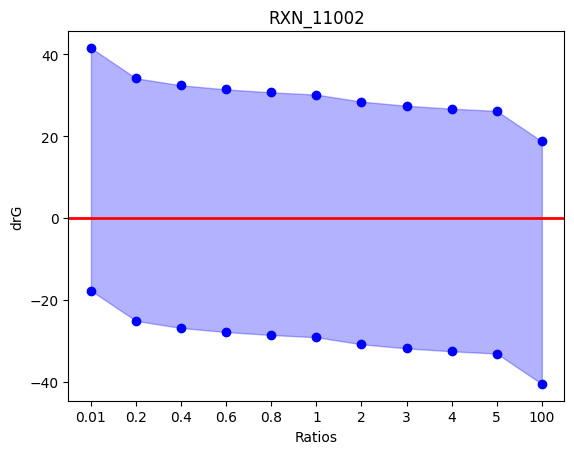

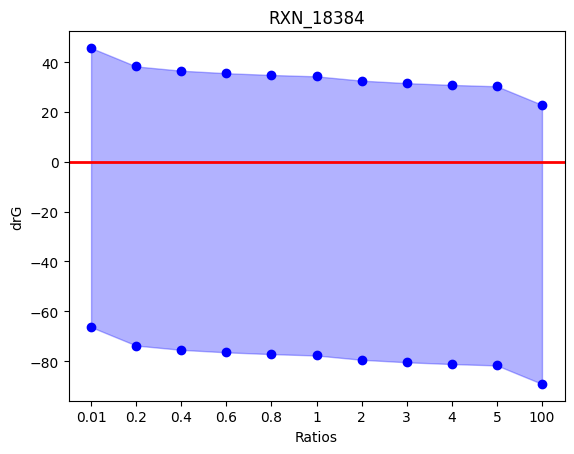

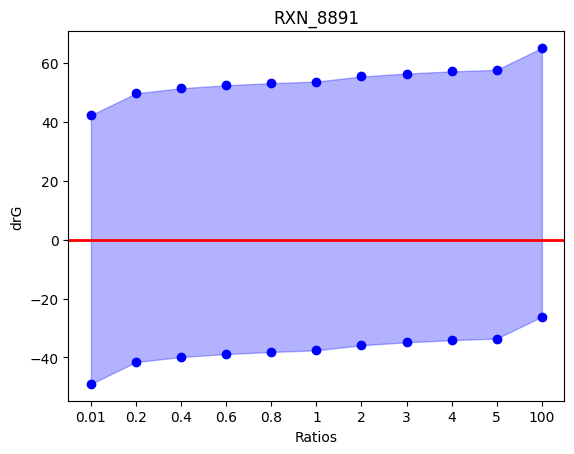

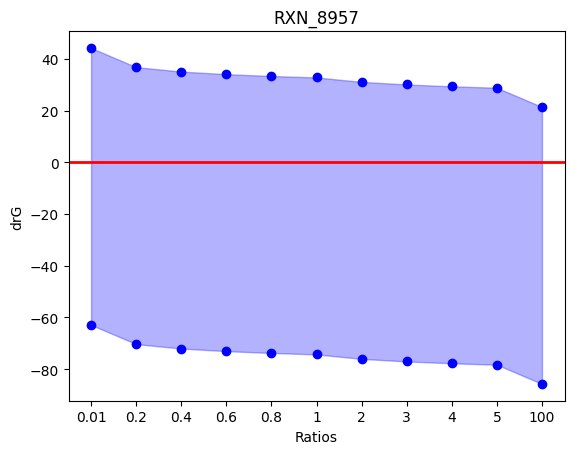

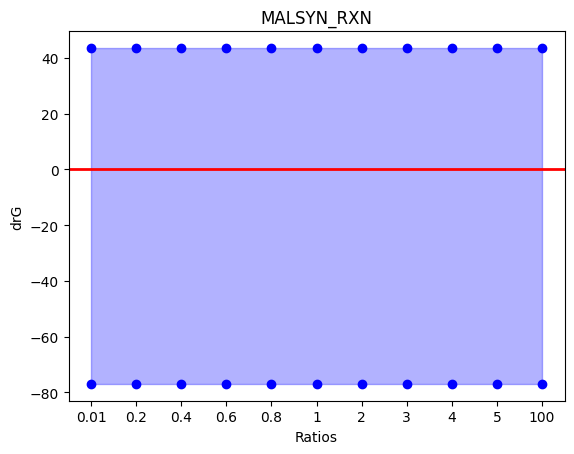

In [ ]:
plot_dataframe_values(["RXN_11002", "RXN_18384", "RXN_8891", "RXN_8957", "MALSYN_RXN"], new_compiled_df)

### Changing NADPH to NADH in CETCH cycle

In [ ]:
import cobra
from cobra import Metabolite

In [ ]:
cetch_model_NADH = cobra.io.read_sbml_model(r"CETCH_cycle_exchange.xml")

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


In [ ]:
model = cetch_model_NADH

# add NADH and NAD+ to the model
NADH_met = Metabolite("NADH", name="NADH", compartment="u", charge = -2, formula = "C21H27N7O14P2")
NADH_met.annotation = {'biocyc': 'META:NADH',
 'metacyc.compound': 'NADH',
 'bigg.metabolite': 'nadh',
 'chebi': 'CHEBI:16908',
 'hmdb': 'HMDB01487',
 'kegg': 'C00004',
 'reactome': '192305.0',
 'sabiork.compound': '38.0',
 'seed': 'cpd00004',
 'metanetx.chemical': 'MNXM89564',
 'synonyms': 'Nicotinamide adenine dinucleotide - reduced',
 'inchi': 'InChI=1/C21H29N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1,3-4,7-8,10-11,13-16,20-21,29-32H,2,5-6H2,(H2,23,33)(H,34,35)(H,36,37)(H2,22,24,25)/p-2/fC21H27N7O14P2/h22-23H2/q-2'}

NAD_met = Metabolite("NAD", name="NAD", compartment="u", charge = -1, formula = "C21H26N7O14P2")
NAD_met.annotation ={'biocyc': 'META:NAD',
 'metacyc.compound': 'NAD',
 'bigg.metabolite': 'nad',
 'chebi': 'CHEBI:15846',
 'hmdb': 'HMDB00902',
 'kegg': 'C00003',
 'reactome': '113526.0',
 'sabiork.compound': '37.0',
 'seed': 'cpd00003',
 'metanetx.chemical': 'MNXM588016',
 'synonyms': 'Nicotinamide adenine dinucleotide',
 'inchi': 'InChI=1/C21H27N7O14P2/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(32)14(30)11(41-21)6-39-44(36,37)42-43(34,35)38-5-10-13(29)15(31)20(40-10)27-3-1-2-9(4-27)18(23)33/h1-4,7-8,10-11,13-16,20-21,29-32H,5-6H2,(H5-,22,23,24,25,33,34,35,36,37)/p-1/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O14P2/h22-23H2/q-1'}

model.add_metabolites([NADH_met, NAD_met])

# change NADPH to NADH, NADP+ to NAD+
for rxn in model.reactions:
    if "NADPH" in [met.id for met in rxn.metabolites]:
        print(rxn.id)
        try:
            rxn.add_metabolites({model.metabolites.NADH:rxn.get_coefficient(model.metabolites.NADPH)*1,
                                 model.metabolites.NAD:rxn.get_coefficient(model.metabolites.NADP)*1})
            
            rxn.add_metabolites({model.metabolites.NADPH:rxn.get_coefficient(model.metabolites.NADPH)*-1,
                                 model.metabolites.NADP:rxn.get_coefficient(model.metabolites.NADP)*-1})
        except:
            pass

rxn = cetch_model_NADH.reactions.NADPH_tx

rxn.add_metabolites({cetch_model_NADH.metabolites.NADH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*1})

rxn.add_metabolites({cetch_model_NADH.metabolites.NADPH:rxn.get_coefficient(cetch_model_NADH.metabolites.NADPH)*-1})


rxn = cetch_model_NADH.reactions.NADP_tx

rxn.add_metabolites({cetch_model_NADH.metabolites.NAD:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*1})

rxn.add_metabolites({cetch_model_NADH.metabolites.NADP:rxn.get_coefficient(cetch_model_NADH.metabolites.NADP)*-1})

RXN_18384
RXN_8891
RXN_11002
RXN_8957
NADPH_tx


In [ ]:
cetch_model_NADH.objective = cetch_model_NADH.reactions.MALSYN_RXN
sol = cetch_model_NADH.optimize()
cetch_model_NADH.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
ACETYL_COA,ACETYL_COA_tx,250,23,19.33%
ATP,ATP_tx,250,10,8.40%
CARBON_DIOXIDE,CO2_tx,500,1,1.68%
NADH,NADPH_tx,1000,21,70.59%
OXYGEN_MOLECULE,OXYGEN_MOLECULE_tx,500,0,0.00%
PROTON,PROTON_tx,250,0,0.00%
WATER,WATER_tx,250,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ADP,ADP_tx,-250,10,8.40%
CO_A,CO_A_tx,-250,21,17.65%


In [ ]:
tmodel = ThermoModel(cetch_model_NADH, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [ ]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [ ]:
for met in tmodel.metabolites:
    
    met_cmp= met.annotation["biocyc"].replace("META:","")
    met.annotation = {"metacyc.compound":met_cmp}

tmodel.metabolites.CPD_9407.annotation = {'metacyc.compound': 'CPD-9407'}#, 'kegg': 'C18324'}
tmodel.metabolites.METHYL_MALONYL_COA.annotation = {'metacyc.compound': 'METHYL-MALONYL-COA'}#, 'kegg': 'C01213'}
tmodel.metabolites.CARBON_DIOXIDE.annotation = {'metacyc.compound': 'CARBON-DIOXIDE'}

In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

Initilizing component contribution object.../30 GLYOX                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from _compound.sqlite
[████████████████████████████████████████] 30/30 NAD                                  



[]

In [ ]:
#concentration data all in mM 
ConcLimits_df = pd.read_excel('cetch_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'mM')
            met.lower_bound = Q_(lb,'mM')
            print(met.id)

GLYOX
WATER
ACETYL_COA
MAL
CO_A
ATP
4_HYDROXY_BUTYRATE
4_HYDROXY_BUTYRYL_COA
ADP
Pi
NADP
NADPH
SUCC_S_ALD
OXYGEN_MOLECULE
CPD_9407
CPD_9408
HYDROGEN_PEROXIDE
PROPIONYL_COA
ACRYLYL_COA
CPD_9406
CROTONYL_COA
CARBON_DIOXIDE
CPD_17635
CPD_9409
METHYL_MALONYL_COA
SUC_COA
CPD_226
NADH
NAD


In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 30/30 NAD                                  

Estimating dfG0'...
[████████████████████████████████████████] 32/32 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [ ]:
tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


In [ ]:
bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95) 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
tmodel.metabolites.MAL.lower_bound

0.01 <Unit('millimolar')>

In [ ]:
tmodel.metabolites.MAL.upper_bound

20.0 <Unit('millimolar')>

In [ ]:
# for met in tmodel.metabolites:
    
#     met_cmp= met.annotation["biocyc"].replace("META:","")
#     met.annotation = {"metacyc.compound":met_cmp}

# tmodel.metabolites.CPD_9407.annotation = {'metacyc.compound': 'CPD-9407'}#, 'kegg': 'C18324'}
# tmodel.metabolites.METHYL_MALONYL_COA.annotation = {'metacyc.compound': 'METHYL-MALONYL-COA'}#, 'kegg': 'C01213'}
# tmodel.metabolites.CARBON_DIOXIDE.annotation = {'metacyc.compound': 'CARBON-DIOXIDE'}

In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

[████████████████████████████████████████] 32/32 Mg_u                                                  



[]

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 32/32 Mg_u                                 

Estimating dfG0'...
[████████████████████████████████████████] 32/32 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 27/27 WATER_tx                                 



In [ ]:
tmodel.metabolites.NAD

Metabolite identifier,NAD
Name,NAD
Memory address,0x7f6e985e6b00
Formula,C21H26N7O14P2
Compartment,u
In 5 reaction(s),"NADP_tx, RXN_11002, RXN_8891, RXN_8957, RXN_18384"


In [ ]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000]

tmodel.metabolites.NADH.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADH.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

1 millimolar 0.001 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 0.01 millimolar


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000]

tmodel.metabolites.NAD.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NAD.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.001 millimolar 1000 millimolar


Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.01 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.2 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.4 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.6 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

0.8 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

2 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

3 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

4 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

5 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

100 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

1000 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                                       



In [ ]:
calculate_flux_bounds(tmodel, ratio_list, "NADH")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                                                        

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                                       



,0.001,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100,1000
MALSYN_RXN,"[-77.36369501580009, 43.958288620794846]","[-77.36369501579979, 43.95828862079125]","[-77.3636950158004, 43.95828862079149]","[-77.36369501580037, 43.95828862079116]","[-77.36369501580049, 43.95828862079128]","[-77.36369501580018, 43.95828862079143]","[-77.36369501580032, 43.958288620791315]","[-77.36369501579979, 43.958288620791336]","[-77.36369501580198, 43.95828862079156]","[-77.36369501580185, 43.95828862079146]","[-77.36369501580202, 43.95828862079303]","[-77.36369501580197, 43.9582886207935]","[-77.3636950158019, 43.958288620793354]"
RXN_8961,"[-51.96976193011381, 43.851695110443856]","[-51.969761930114515, 43.85169511044795]","[-51.969761930118366, 43.8516951104479]","[-51.96976193011862, 43.85169511044788]","[-51.96976193011835, 43.85169511044796]","[-51.969761930118466, 43.851695110448254]","[-51.969761930118594, 43.85169511044829]","[-51.96976193011851, 43.85169511044802]","[-51.96976193011835, 43.851695110448006]","[-51.96976193011835, 43.851695110448006]","[-51.969761930118324, 43.8516951104482]","[-51.96976193011863, 43.85169511044618]","[-51.96976193011651, 43.851695110445874]"
RXN_15977,"[-144.16197924883858, 0.42471952676770286]","[-144.16197924883852, 0.4247195267672126]","[-144.16197924883886, 0.4247195267676176]","[-144.1619792488392, 0.4247195267676602]","[-144.1619792488393, 0.4247195267675039]","[-144.16197924883954, 0.42471952676796576]","[-144.1619792488388, 0.4247195267678805]","[-144.161979248839, 0.4247195267677526]","[-144.16197924883951, 0.42471952676795866]","[-144.16197924883895, 0.42471952676795866]","[-144.16197924883915, 0.4247195267677881]","[-144.16197924883932, 0.4247195267673334]","[-144.16197924883886, 0.42471952676766733]"
RXN_18384,"[-61.553554176566195, 52.066792798618835]","[-67.25850002147331, 46.36184695371615]","[-74.68080568933615, 38.9395412858495]","[-76.39816551229177, 37.22218146289505]","[-77.40275660896617, 36.2175903662213]","[-78.1155253352471, 35.50482163993972]","[-78.66839171128717, 34.95195526389976]","[-80.38575153424286, 33.234595440945434]","[-81.39034263091693, 32.23000434427108]","[-82.1031113571984, 31.51723561798619]","[-82.65597773323887, 30.964369241945725]","[-90.07828340110137, 23.5420635740851]","[-95.7832292460083, 17.837117772069625]"
METHYLMALONYL_COA_MUT_RXN,"[-40.709975622608816, 24.003041886562748]","[-40.709975622609036, 24.00304188656278]","[-40.70997562260902, 24.003041886562762]","[-40.70997562260899, 24.003041886562823]","[-40.70997562260896, 24.003041886562645]","[-40.70997562260883, 24.00304188656281]","[-40.70997562260901, 24.003041886563015]","[-40.70997562260929, 24.003041886562873]","[-40.70997562261118, 24.003041886564912]","[-40.70997562261127, 24.003041886565]","[-40.70997562261108, 24.00304188656508]","[-40.70997562261134, 24.00304188656507]","[-40.709975622611196, 24.003041886564997]"
RXN_8891,"[-54.98835956218732, 37.12035804329095]","[-49.28341371728481, 42.82530388820185]","[-41.86110804942237, 50.247609556064035]","[-40.143748226466634, 51.9649693790199]","[-39.13915712979256, 52.96956047569405]","[-38.42638840351091, 53.68232920197555]","[-37.87352202747073, 54.23519557801568]","[-36.15616220451535, 55.95255540097127]","[-35.15157110784129, 56.95714649764554]","[-34.438802381559604, 57.66991522392726]","[-33.88593600551924, 58.22278159996726]","[-26.463630337654813, 65.64508726782779]","[-20.75868449274786, 71.35003311273496]"
RXN_11002,"[-12.401639755769926, 47.39608554603177]","[-18.10658560067713, 41.69113970112499]","[-25.528891268539923, 34.268834033262564]","[-27.246251091495544, 32.55147421030699]","[-28.250842188169592, 31.54688311363294]","[-28.963610914451074, 30.83411438735146]","[-29.516477290491455, 30.28124801131134]","[-31.233837113446995, 28.563888188355687]","[-32.238428210121235, 27.559297091681685]","[-32.951196936402596, 26.846528365400196]","[-33.50406331244293, 26.293661989360075]","[-40.92636898030557, 18.871356321497387]","[-46.631314825212584, 13.1

In [ ]:
new_compiled_df = calculate_flux_bounds(tmodel, ratio_list, "NADH")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



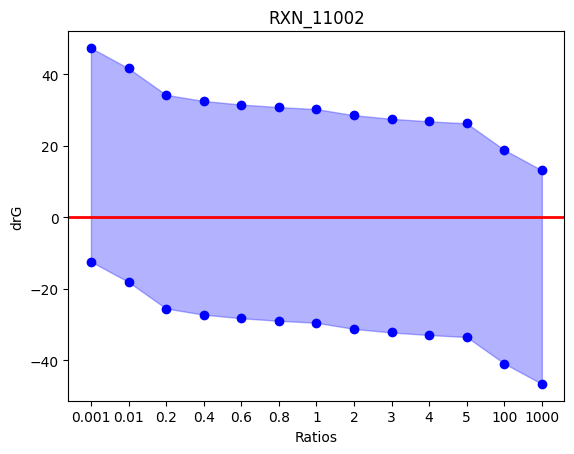

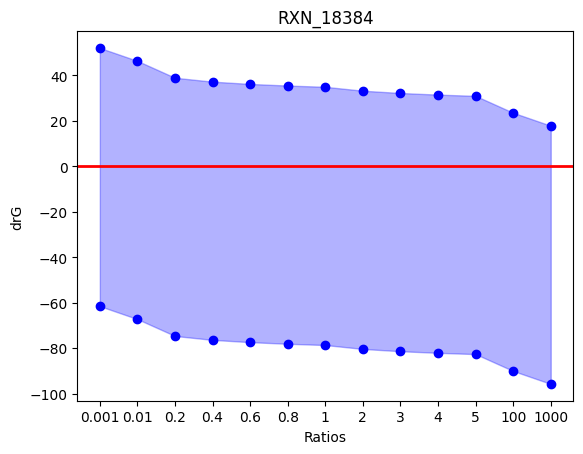

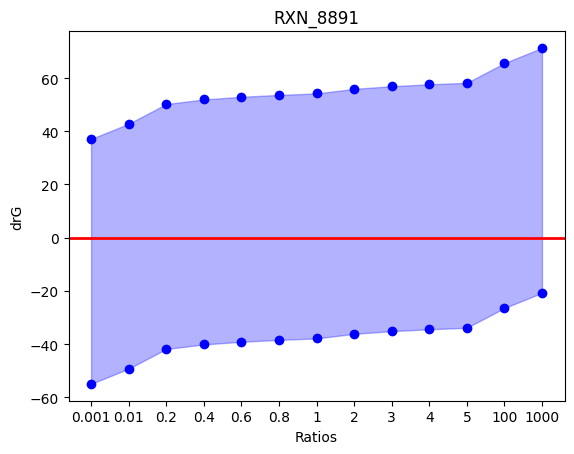

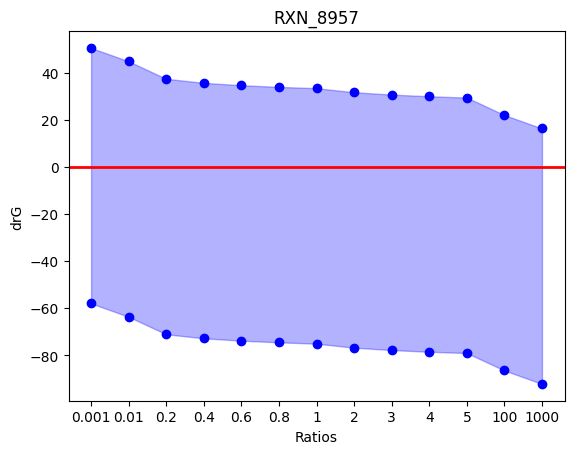

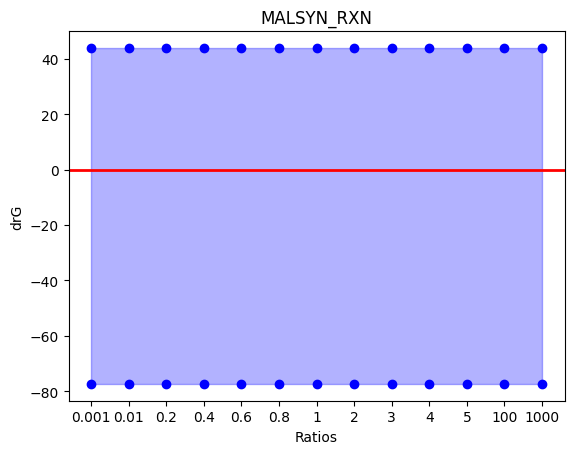

In [ ]:
plot_dataframe_values(["RXN_11002", "RXN_18384", "RXN_8891", "RXN_8957", "MALSYN_RXN"], new_compiled_df)

In [ ]:
new_compiled_df = calculate_flux_bounds(tmodel, ratio_list, "ATP")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                                       

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 27/27 WATER_tx                             



In [ ]:
ATP_reactions = list()
for rxn in tmodel.reactions:
    for met in rxn.metabolites:
        if met.id == "ATP":
            ATP_reactions.append(rxn.id)

In [ ]:
ATP_reactions

['RXN_18387', 'ATP_tx']

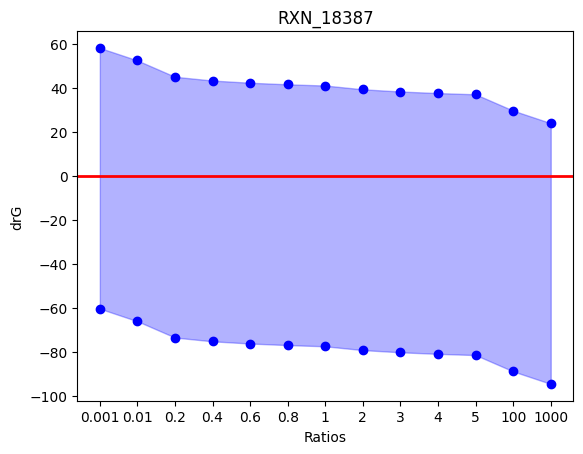

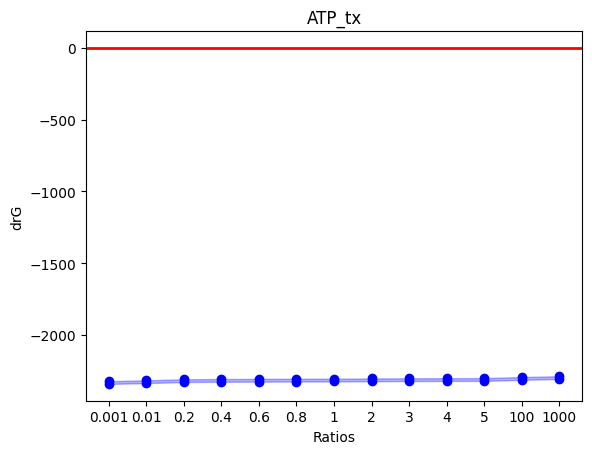

In [ ]:
plot_dataframe_values(ATP_reactions, new_compiled_df)

### studying NADH kinase

In [ ]:
cetch_NADH_kinase_model = cetch_model_NADH.copy()

Read LP format model from file /tmp/tmp1tekqjrd.lp
Reading time = 0.00 seconds
: 32 rows, 54 columns, 138 nonzeros


In [ ]:
"ATP_c_00 + NADH_c_00 --> ADP_c_00 + NADPH_c_00 + 0.84 PROTON_c_00"

'ATP_c_00 + NADH_c_00 --> ADP_c_00 + NADPH_c_00 + 0.84 PROTON_c_00'

In [ ]:
cetch_NADH_kinase_model.metabolites

[<Metabolite GLYOX at 0x7f6e949b36a0>,
 <Metabolite WATER at 0x7f6e949b2230>,
 <Metabolite ACETYL_COA at 0x7f6e949b0670>,
 <Metabolite PROTON at 0x7f6e949b0070>,
 <Metabolite MAL at 0x7f6e949b0190>,
 <Metabolite CO_A at 0x7f6e949b20e0>,
 <Metabolite ATP at 0x7f6e949b0a90>,
 <Metabolite 4_HYDROXY_BUTYRATE at 0x7f6e949b3c70>,
 <Metabolite 4_HYDROXY_BUTYRYL_COA at 0x7f6e949b17e0>,
 <Metabolite ADP at 0x7f6e949b2200>,
 <Metabolite Pi at 0x7f6e949b3e80>,
 <Metabolite NADP at 0x7f6e949b1780>,
 <Metabolite NADPH at 0x7f6e949b3b80>,
 <Metabolite SUCC_S_ALD at 0x7f6e949b3d60>,
 <Metabolite OXYGEN_MOLECULE at 0x7f6e949b2cb0>,
 <Metabolite CPD_9407 at 0x7f6e949b2860>,
 <Metabolite CPD_9408 at 0x7f6e949b2260>,
 <Metabolite HYDROGEN_PEROXIDE at 0x7f6e949b0460>,
 <Metabolite PROPIONYL_COA at 0x7f6e949b3a30>,
 <Metabolite ACRYLYL_COA at 0x7f6e949b0a30>,
 <Metabolite CPD_9406 at 0x7f6e949b0910>,
 <Metabolite CROTONYL_COA at 0x7f6e949b32e0>,
 <Metabolite CARBON_DIOXIDE at 0x7f6e949b3850>,
 <Metabolite 

In [ ]:

NADH_kinase_rxn = Reaction("NADH_kinase")
NADH_kinase_rxn.upper_bound = 1000.0
NADH_kinase_rxn.lower_bound = -1000.0
NADH_kinase_rxn.add_metabolites({cetch_NADH_kinase_model.metabolites.ATP : -1, 
                            cetch_NADH_kinase_model.metabolites.NADH : -1, 
                            cetch_NADH_kinase_model.metabolites.ADP : 1, 
                            cetch_NADH_kinase_model.metabolites.NADPH : 1, 
                            cetch_NADH_kinase_model.metabolites.PROTON : 0.84})
cetch_NADH_kinase_model.add_reactions([NADH_kinase_rxn])



In [ ]:
tmodel = ThermoModel(cetch_NADH_kinase_model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [ ]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [ ]:
for met in tmodel.metabolites:
    
    met_cmp= met.annotation["biocyc"].replace("META:","")
    met.annotation = {"metacyc.compound":met_cmp}

tmodel.metabolites.CPD_9407.annotation = {'metacyc.compound': 'CPD-9407'}#, 'kegg': 'C18324'}
tmodel.metabolites.METHYL_MALONYL_COA.annotation = {'metacyc.compound': 'METHYL-MALONYL-COA'}#, 'kegg': 'C01213'}
tmodel.metabolites.CARBON_DIOXIDE.annotation = {'metacyc.compound': 'CARBON-DIOXIDE'}

In [ ]:
# #concentration data all in M 
ConcLimits_df = pd.read_excel('Henry2009_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'mM')
            met.lower_bound = Q_(lb,'mM')
            print(met.id)


WATER
MAL
CO_A
ATP
ADP
Pi
NADP
NADPH
OXYGEN_MOLECULE
CARBON_DIOXIDE
NADH
NAD


In [ ]:
for met in tmodel.metabolites:
    print(met.id, "\t", met.lower_bound, "\t", met.upper_bound)

GLYOX 	 0.1 micromolar 	 10 millimolar
WATER 	 0.01 millimolar 	 20.0 millimolar
ACETYL_COA 	 0.1 micromolar 	 10 millimolar
PROTON 	 1 molar 	 1 molar
MAL 	 0.01 millimolar 	 20.0 millimolar
CO_A 	 0.01 millimolar 	 20.0 millimolar
ATP 	 0.01 millimolar 	 20.0 millimolar
4_HYDROXY_BUTYRATE 	 0.1 micromolar 	 10 millimolar
4_HYDROXY_BUTYRYL_COA 	 0.1 micromolar 	 10 millimolar
ADP 	 0.01 millimolar 	 20.0 millimolar
Pi 	 0.01 millimolar 	 20.0 millimolar
NADP 	 0.01 millimolar 	 20.0 millimolar
NADPH 	 0.01 millimolar 	 20.0 millimolar
SUCC_S_ALD 	 0.1 micromolar 	 10 millimolar
OXYGEN_MOLECULE 	 0.01 millimolar 	 20.0 millimolar
CPD_9407 	 0.1 micromolar 	 10 millimolar
CPD_9408 	 0.1 micromolar 	 10 millimolar
HYDROGEN_PEROXIDE 	 0.1 micromolar 	 10 millimolar
PROPIONYL_COA 	 0.1 micromolar 	 10 millimolar
ACRYLYL_COA 	 0.1 micromolar 	 10 millimolar
CPD_9406 	 0.1 micromolar 	 10 millimolar
CROTONYL_COA 	 0.1 micromolar 	 10 millimolar
CARBON_DIOXIDE 	 0.01 millimolar 	 20.0 millimo

In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

Initilizing component contribution object.../30 GLYOX                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from _compound.sqlite
[████████████████████████████████████████] 30/30 NAD                                  



[]

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 30/30 NAD                                  

Estimating dfG0'...
[████████████████████████████████████████] 32/32 Mg_u                                 

Estimating drG0'...
[████████████████████████████████████████] 28/28 NADH_kinase                              



In [ ]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000]

tmodel.metabolites.NADH.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADH.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADH.lower_bound , tmodel.metabolites.NADPH.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

1 millimolar 0.001 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          

1 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


[████████████████████████████████████████] 28/28 NADH_kinase                          



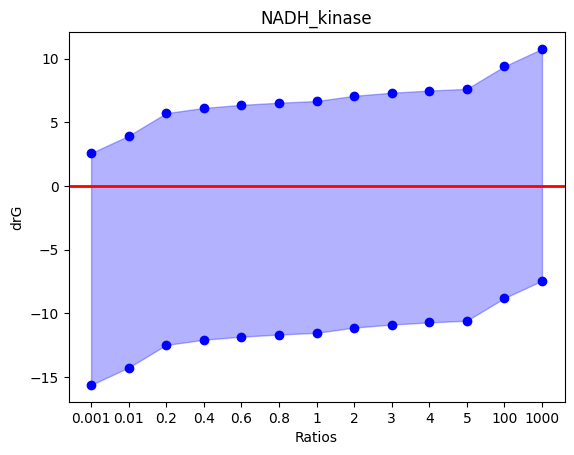

In [ ]:
plot_dataframe_values(["NADH_kinase"], new_compiled_df)

### studying NADP-dependent malate dehydrogenase

In [ ]:
test_model = cobra.Model("pMDH_test")


# add NADH and NAD+ to the model
NADPH_met = Metabolite("NADPH", name="NADPH", compartment="u")
NADP_met = Metabolite("NADP", name="NADP", compartment="u")
MAL = Metabolite("MAL", name="MAL", compartment="u")
OAA = Metabolite("OXALACETIC_ACID", name="OXALACETIC_ACID", compartment="u")
PROTON = Metabolite("PROTON", name="PROTON", compartment="u")

OAA.annotation = {'biocyc': 'META:OXALACETIC_ACID', 'metacyc.compound': 'OXALACETIC_ACID', 'bigg.metabolite': 'oaa', 'chebi': 'CHEBI:16452', 'envipath': '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/be7c543c-40bd-4698-9821-22f2e65c38f3', 'hmdb': 'HMDB00223', 'kegg': 'C00036', 'reactome': '113587.0', 'sabiork.compound': '1915.0', 'seed': 'cpd00032', 'metanetx.chemical': 'MNXM89644', 'synonyms': 'Oxaloacetate', 'lipidmaps': 'LMFA01170120'}
NADPH_met.annotation = {'biocyc': 'META:NADPH', 'metacyc.compound': 'NADPH', 'bigg.metabolite': 'nadph', 'chebi': 'CHEBI:16474', 'hmdb': 'HMDB00221', 'kegg': 'C00005', 'reactome': '113600.0', 'sabiork.compound': '1262.0', 'seed': 'cpd00005', 'metanetx.chemical': 'MNXM64104', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate - reduced', 'inchi': 'InChI=1/C21H30N7O17P3/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32/h1,3-4,7-8,10-11,13-16,20-21,29-31H,2,5-6H2,(H2,23,32)(H,36,37)(H,38,39)(H2,22,24,25)(H2,33,34,35)/p-4/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O17P3/h22-23H2/q-4'}
PROTON.annotation = {'biocyc': 'META:PROTON', 'metacyc.compound': 'PROTON', 'bigg.metabolite': 'h', 'chebi': 'CHEBI:15378', 'hmdb': 'HMDB59597', 'kegg': 'C00080', 'reactome': '1132304.0', 'sabiork.compound': '39.0', 'seed': 'cpd00067', 'metanetx.chemical': 'MNXM145872', 'synonyms': 'H+', 'inchi': 'NIL'}
MAL.annotation = {'biocyc': 'META:MAL', 'metacyc.compound': 'MAL', 'bigg.metabolite': 'mal__L', 'chebi': 'CHEBI:15589', 'hmdb': 'HMDB00156', 'kegg': 'C00149', 'reactome': '113544.0', 'sabiork.compound': '1918.0', 'seed': 'cpd00130', 'metanetx.chemical': 'MNXM89610', 'synonyms': 'L-Malate', 'inchi': 'InChI=1/C4H6O5/c5-2(4(8)9)1-3(6)7/h2,5H,1H2,(H,6,7)(H,8,9)/p-2/fC4H4O5/q-2'}
NADP_met.annotation = {'biocyc': 'META:NADP', 'metacyc.compound': 'NADP', 'bigg.metabolite': 'nadp', 'chebi': 'CHEBI:18009', 'hmdb': 'HMDB00217', 'kegg': 'C00006', 'reactome': '113563.0', 'sabiork.compound': '1263.0', 'seed': 'cpd00006', 'metanetx.chemical': 'MNXM588022', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate', 'inchi': 'InChI=1/C21H28N7O17P3/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32/h1-4,7-8,10-11,13-16,20-21,29-31H,5-6H2,(H7-,22,23,24,25,32,33,34,35,36,37,38,39)/p-3/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H25N7O17P3/h22-23H2/q-3'}

test_model.add_metabolites([NADPH_met, NADP_met, MAL, OAA, PROTON])

pMDH_rxn = Reaction("pMDH")
pMDH_rxn.upper_bound = 1000.0
pMDH_rxn.lower_bound = -1000.0
pMDH_rxn.add_metabolites({test_model.metabolites.NADPH : -1, 
                        test_model.metabolites.OXALACETIC_ACID: -1,
                        test_model.metabolites.PROTON: -1,
                        test_model.metabolites.NADP: 1,
                        test_model.metabolites.MAL: 1})
test_model.add_reactions([pMDH_rxn])

# test_model = cobra.io.read_sbml_model(r"PlantCoreMetabolism_v3_0_1.xml")
test_model.objective = test_model.reactions.pMDH
sol = test_model.optimize()
test_model.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [ ]:
tmodel = ThermoModel(test_model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [ ]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [ ]:
# #concentration data all in M 
ConcLimits_df = pd.read_excel('Henry2009_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'mM')
            met.lower_bound = Q_(lb,'mM')
            print(met.id)


NADPH
NADP
MAL
OXALACETIC_ACID


In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

Initilizing component contribution object.../5 NADPH                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Loading compounds from pMDH_test_compound.sqlite
[████████████████████████████████████████] 5/5 PROTON                          



[]

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 5/5 PROTON                          

Estimating dfG0'...
[████████████████████████████████████████] 7/7 Mg_u                            

Estimating drG0'...
[████████████████████████████████████████] 1/1 pMDH                 



In [ ]:
tmodel.reactions.pMDH

Reaction identifier,pMDH
Name,
Memory address,0x7f6e95cd6ef0
Stoichiometry,NADPH + OXALACETIC_ACID + PROTON <=> MAL + NADP NADPH + OXALACETIC_ACID + PROTON <=> MAL + NADP
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [ ]:
for met in tmodel.metabolites:
    print(met.id,"\t", met.lower_bound, met.upper_bound)

NADPH 	 0.01 millimolar 20.0 millimolar
NADP 	 0.01 millimolar 20.0 millimolar
MAL 	 0.01 millimolar 20.0 millimolar
OXALACETIC_ACID 	 0.01 millimolar 20.0 millimolar
PROTON 	 1 molar 1 molar
charge_u 	 0.1 micromolar 10 millimolar
Mg_u 	 0.1 micromolar 10 millimolar


In [ ]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000]

tmodel.metabolites.NADP.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADP.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NADPH.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NADPH.lower_bound = Q_(item, 'mM')

    print(tmodel.metabolites.NADPH.lower_bound , tmodel.metabolites.NADPH.upper_bound)
    print(tmodel.metabolites.NADP.lower_bound)
    print("ratio:", tmodel.metabolites.NADPH.lower_bound/tmodel.metabolites.NADP.lower_bound)


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    new_compiled_df[str(value)] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.001 millimolar 0.001 millimolar
1 millimolar
ratio: 0.001 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

0.01 millimolar 0.01 millimolar
1 millimolar
ratio: 0.01 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

0.2 millimolar 0.2 millimolar
1 millimolar
ratio: 0.2 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

0.4 millimolar 0.4 millimolar
1 millimolar
ratio: 0.4 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10


[████████████████████████████████████████] 1/1 pMDH                 

0.6 millimolar 0.6 millimolar
1 millimolar
ratio: 0.6 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

0.8 millimolar 0.8 millimolar
1 millimolar
ratio: 0.8 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

1 millimolar 1 millimolar
1 millimolar
ratio: 1.0 dimensionless
Set parameter NonConvex to value 2


/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2

Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

2 millimolar 2 millimolar
1 millimolar
ratio: 2.0 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

3 millimolar 3 millimolar
1 millimolar
ratio: 3.0 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

4 millimolar 4 millimolar
1 millimolar
ratio: 4.0 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

5 millimolar 5 millimolar
1 millimolar
ratio: 5.0 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 

100 millimolar 100 millimolar
1 millimolar
ratio: 100.0 dimensionless
Set 

/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2



1000 millimolar 1000 millimolar
1 millimolar
ratio: 1000.0 dimensionless
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 pMDH                 



/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [ ]:
new_compiled_df

,0.001,0.01,0.2,0.4,0.6,0.8,1,2,3,4,5,100,1000
pMDH,"[-7.8178394614714355, 1.932170916202255]","[-9.181354242758706, 0.5686561349144786]","[-10.955327872744679, -1.205317495072087]","[-11.365786721443415, -1.615776343770934]","[-11.605889756021265, -1.8558793783489291]","[-11.776245570142041, -2.026235192469781]","[-11.908383805333266, -2.158373427661022]","[-12.318842654031979, -2.5688322763599163]","[-12.55894568860988, -2.808935310937785]","[-12.729301502730669, -2.979291125058728]","[-12.861439737921975, -3.111429360249966]","[-14.635413367908022, -4.885402990236413]","[-15.998928149195505, -6.248917771523992]"


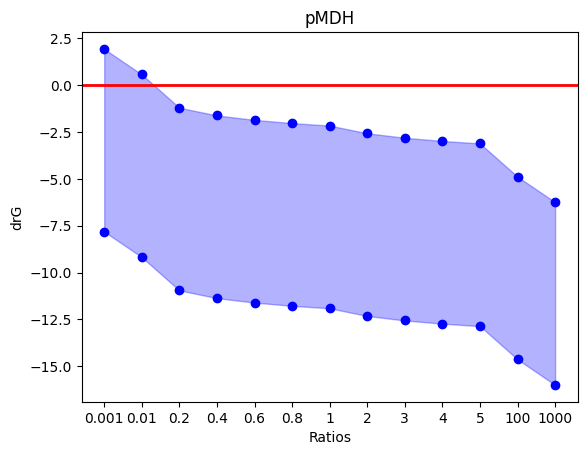

In [ ]:
plot_dataframe_values(["pMDH"], new_compiled_df)

In [ ]:
for met in tmodel.metabolites:
    print(met.id, met.annotation)

NADPH {'biocyc': 'META:NADPH', 'metacyc.compound': 'NADPH', 'bigg.metabolite': 'nadph', 'chebi': 'CHEBI:16474', 'hmdb': 'HMDB00221', 'kegg': 'C00005', 'reactome': '113600.0', 'sabiork.compound': '1262.0', 'seed': 'cpd00005', 'metanetx.chemical': 'MNXM64104', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate - reduced', 'inchi': 'InChI=1/C21H30N7O17P3/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32/h1,3-4,7-8,10-11,13-16,20-21,29-31H,2,5-6H2,(H2,23,32)(H,36,37)(H,38,39)(H2,22,24,25)(H2,33,34,35)/p-4/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O17P3/h22-23H2/q-4'}
NADP {'biocyc': 'META:NADP', 'metacyc.compound': 'NADP', 'bigg.metabolite': 'nadp', 'chebi': 'CHEBI:18009', 'hmdb': 'HMDB00217', 'kegg': 'C00006', 'reactome': '113563.0', 'sabiork.compound': '1263.0', 'seed': 'cpd00006', 'metanetx.chemical': 'MNXM588022', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate', 'i

### studying native PROPCOASYN_RXN

Name,
Memory address,7f6e993806d0
Number of metabolites,30
Number of reactions,27
Number of genes,0
Number of groups,0
Objective expression,1.0*MALSYN_RXN - 1.0*MALSYN_RXN_reverse_25886
Compartments,u


In [ ]:
############ change for PROPCOASYN_RXN!!!!!!!! ################


# test_model = cobra.Model("PROPCOASYN_RXN_test")


# # add NADH and NAD+ to the model
# NADPH_met = Metabolite("NADPH", name="NADPH", compartment="u")
# NADP_met = Metabolite("NADP", name="NADP", compartment="u")
# NADP_met.annotation = {'biocyc': 'META:NADP', 'metacyc.compound': 'NADP', 'bigg.metabolite': 'nadp', 'chebi': 'CHEBI:18009', 'hmdb': 'HMDB00217', 'kegg': 'C00006', 'reactome': '113563.0', 'sabiork.compound': '1263.0', 'seed': 'cpd00006', 'metanetx.chemical': 'MNXM588022', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate', 'inchi': 'InChI=1/C21H28N7O17P3/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32/h1-4,7-8,10-11,13-16,20-21,29-31H,5-6H2,(H7-,22,23,24,25,32,33,34,35,36,37,38,39)/p-3/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H25N7O17P3/h22-23H2/q-3'}
# NADPH_met.annotation = {'biocyc': 'META:NADPH', 'metacyc.compound': 'NADPH', 'bigg.metabolite': 'nadph', 'chebi': 'CHEBI:16474', 'hmdb': 'HMDB00221', 'kegg': 'C00005', 'reactome': '113600.0', 'sabiork.compound': '1262.0', 'seed': 'cpd00005', 'metanetx.chemical': 'MNXM64104', 'synonyms': 'Nicotinamide adenine dinucleotide phosphate - reduced', 'inchi': 'InChI=1/C21H30N7O17P3/c22-17-12-19(25-7-24-17)28(8-26-12)21-16(44-46(33,34)35)14(30)11(43-21)6-41-48(38,39)45-47(36,37)40-5-10-13(29)15(31)20(42-10)27-3-1-2-9(4-27)18(23)32/h1,3-4,7-8,10-11,13-16,20-21,29-31H,2,5-6H2,(H2,23,32)(H,36,37)(H,38,39)(H2,22,24,25)(H2,33,34,35)/p-4/t10-,11-,13-,14-,15-,16-,20-,21-/m1/s1/fC21H26N7O17P3/h22-23H2/q-4'}



# test_model.add_metabolites([NADPH_met, NADP_met, MAL, OAA, PROTON])

# test_rxn = Reaction("PROPCOASYN_RXN")
# test_rxn.upper_bound = 1000.0
# test_rxn.lower_bound = -1000.0
# test_rxn.add_metabolites({test_model.metabolites.NAD : -1, 
#                         test_model.metabolites.PROPIONYL_COA: -1,
#                         test_model.metabolites.ACRYLYL_COA: 1,
#                         test_model.metabolites.NADH: 1,
#                         test_model.metabolites.PROTON: 1})
# test_model.add_reactions([test_rxn])

plant_model = cobra.io.read_sbml_model(r"PlantCoreMetabolism_v3_0_1.xml")

test_model = cobra.Model("test")

test_model.add_reactions([plant_model.reactions.PROPCOASYN_RXN_x])

test_model.objective = test_model.reactions.PROPCOASYN_RXN_x
sol = test_model.optimize()
test_model.summary(sol)

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [ ]:
test_model.reactions.PROPCOASYN_RXN_x

Reaction identifier,PROPCOASYN_RXN_x
Name,PROPCOASYN-RXN:NIL
Memory address,0x7f6e899739a0
Stoichiometry,NAD_x + PROPIONYL_COA_x --> ACRYLYL_COA_x + NADH_x + PROTON_x NAD + PROPIONYL-COA --> ACRYLYL-COA + NADH + PROTON
GPR,
Lower bound,0.0
Upper bound,1000.0


In [ ]:
tmodel = ThermoModel(test_model, split_biomass=False, add_charge_exchange=False) #flags prevent modifications that are important for thermodynamc analysis and charge balancing but we don't need them here

In [ ]:
#set the pH of each compartment
tmodel.pH = {'m': Q_(8.1),
 'c': Q_(7.3),
 'b': Q_(7.3),
 'p': Q_(8.0),
 'v': Q_(5.2),
 'x': Q_(7.5),
 'r': Q_(7.1),
 'e': Q_(4.7),
 'l': Q_(6.0),
 'i': Q_(7.3)}

#Define a constant ionic strength for each compartment
tmodel.I = {comp: Q_(0.25, 'M') for comp in tmodel.compartments}

#Set the temperature of the model
tmodel.T = Q_(298.15, 'K')

#define mebrane potential for each compartment
tmodel.phi = {'pl':Q_(0,'V'), 
               'pc':Q_(-0.111,'V'),
               'cm':Q_(-0.160,'V'),
               'ce':Q_(0.150,'V'),
               'cx':Q_(0,'V'),
               'cv':Q_(0.02,'V')}

In [ ]:
# #concentration data all in M 
ConcLimits_df = pd.read_excel('Henry2009_conc_limits.xlsx', 
                   header=[0,1], 
                   index_col=[0]                   
                   )

for met in tmodel.metabolites:
    # if met.id[:-2] in list(ConcLimits_df.index):
    #     if met.id[:-2] not in ['charge', 'PROTON']:
    if met.id in list(ConcLimits_df.index):
        if met.id not in ['charge', 'PROTON']:
            # ub = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'up')])
            # lb = (ConcLimits_df.loc[met.id[:-2]][(met.compartment,'lo')])
            ub = (ConcLimits_df.loc[met.id][(met.compartment,'up')])
            lb = (ConcLimits_df.loc[met.id][(met.compartment,'lo')])
            met.upper_bound = Q_(ub,'mM')
            met.lower_bound = Q_(lb,'mM')
            print(met.id)


In [ ]:
#idnetify all the compounds that are in the model
tmodel.get_compounds(search = True, update_annotations = True)

Initilizing component contribution object.../5 PROPIONYL_COA_x                 
No valid license for cxcalc installed, operating in read-only mode. A local cache may be loaded, but no compounds can be created. Please obtain a ChemAxon license to enable compound creation.
Copying default Zenodo compound cache to test_compound.sqlite
Loading compounds from test_compound.sqlite
[████████████████████████████████████████] 5/5 PROTON_x                      



[]

In [ ]:
tmodel.update_thermo_info()

Identifying compounds...
[████████████████████████████████████████] 5/5 PROTON_x                        

Estimating dfG0'...
[████████████████████████████████████████] 7/7 Mg_x                            

Estimating drG0'...
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 



In [ ]:
ratio_list = [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4, 5, 100, 1000, 1100]

tmodel.metabolites.NADH_x.lower_bound = Q_(1, 'mM')
tmodel.metabolites.NADH_x.upper_bound = Q_(1, 'mM')



compiled_df = pd.DataFrame()

for item in ratio_list:
    try:
        tmodel.metabolites.NAD_x.lower_bound = Q_(item, 'mM')
        tmodel.metabolites.NAD_x.upper_bound = Q_(item, 'mM')
    except:
        tmodel.metabolites.NAD_x.upper_bound = Q_(item, 'mM')
        tmodel.metabolites.NAD_x.lower_bound = Q_(item, 'mM')

    print(item)
    print(tmodel.metabolites.NADH_x.lower_bound , tmodel.metabolites.NAD_x.upper_bound) 


    tmodel.m = None #reset the gurobi model object in case you're re-running this cell 
    tmodel.add_TFBA_variables(gdiss_constraint = False, qnorm=1,error_type='covariance')
    bounds_df = thermo_flux.solver.gurobi.drG_bounds(tmodel, alpha=0.95)
    bounds_kcal = Q_(bounds_df.values, 'kJ/mol').to('kcal/mol').m
    bounds_df_kcal = pd.DataFrame(bounds_kcal, index=bounds_df.index, columns=bounds_df.columns)

    # Add bounds_df.lb and bounds_df.ub for each iteration to the compiled_df
    compiled_df.insert(0, str(item)+"_ub", bounds_df_kcal.ub, False)
    compiled_df.insert(0, str(item)+"_lb", bounds_df_kcal.lb, False)



new_compiled_df = pd.DataFrame()
new_compiled_df.index = compiled_df.index

for value in ratio_list:
    x = 0
    while round(1/value, x) == 0.0:
        x += 1
    new_compiled_df[str(round(1/value,x))] = [[a,b] for a, b in zip(compiled_df[str(value)+"_lb"], compiled_df[str(value)+"_ub"])]

0.001
1 millimolar 0.001 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

0.01
1 millimolar 0.01 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

0.2
1 millimolar 0.2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

0.4
1 millimolar 0.4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10




0.6
1 millimolar 0.6 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

0.8
1 millimolar 0.8 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 



/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2

1
1 millimolar 1 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

2
1 millimolar 2 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

3
1 millimolar 3 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

4
1 millimolar 4 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

5
1 millimolar 5 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 



/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2

100
1 millimolar 100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

1000
1 millimolar 1000 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 

1100
1 millimolar 1100 millimolar
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
[████████████████████████████████████████] 1/1 PROPCOASYN_RXN_x                 



/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/corinna/anaconda3/envs/thermoflux2

In [ ]:
new_compiled_df

,1000.0,100.0,5.0,2.0,1.0,0.5,0.3,0.2,0.01,0.001
PROPCOASYN_RXN_x,"[8.187097718429058, 27.482137934573416]","[6.823582937143125, 26.11862315328436]","[5.04960930715846, 24.344649523296404]","[4.39904742388224, 23.69408764001907]","[4.0965533745704175, 23.39159359070686]","[3.686094525871926, 22.98113474200789]","[3.445991491294135, 22.741031707429755]","[3.143497441982222, 22.438537658117543]","[1.3695238119966702, 20.66456402813054]","[-0.05043050734111799, 19.244609708792417]"


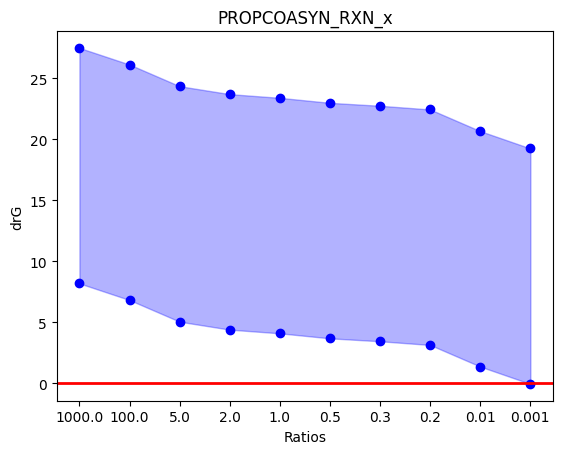

In [ ]:
plot_dataframe_values(["PROPCOASYN_RXN_x"], new_compiled_df)

### reversibility scoring

In [ ]:
drGmprime_df = pd.DataFrame(columns=['reaction','drGmprime','drG_SE'])
df_list = []

for rxn in tmodel.reactions:
    data ={'reaction':rxn.id, 'drGmprime':rxn.drGmprime.m_as('kcal/mol'), 'drG_SE':rxn.drG_SE.m_as('kcal/mol')}
    df_list.append(pd.DataFrame(data, index=[0]))

drGmprime_df = pd.concat(df_list)

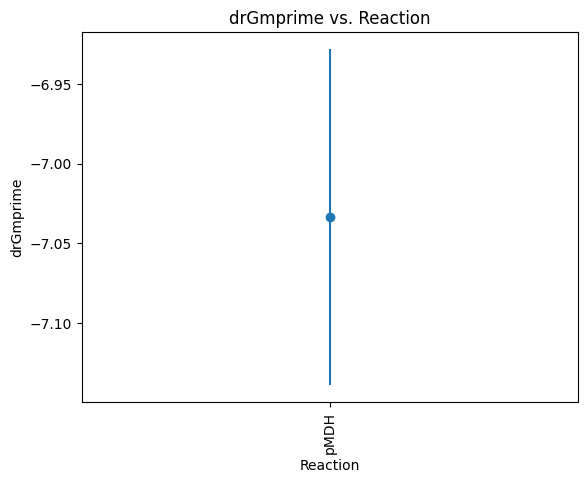

In [ ]:
rxn_list1 = [rxn.id for rxn in tmodel.reactions if not rxn.id.endswith("_tx")]

plot_reaction(drGmprime_df, rxn_list1)

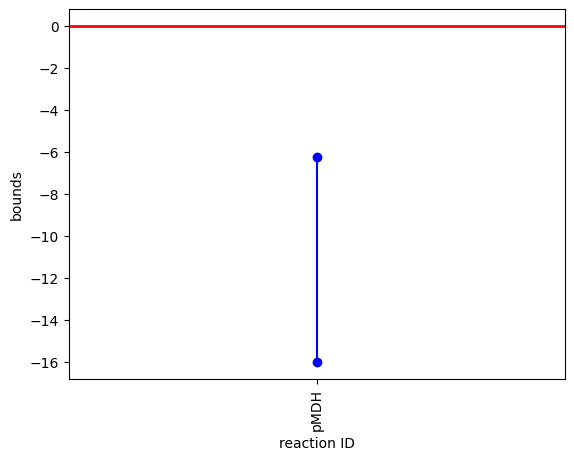

In [ ]:
rxn_list1 = [rxn.id for rxn in tmodel.reactions if not rxn.id.endswith("_tx")]

plot_reaction_bounds(bounds_df_kcal, rxn_list1)

In [ ]:
drGmprime_df

,reaction,drGmprime,drG_SE
0,pMDH,-7.033379,0.105398


In [ ]:
############################################################################################################################
# function to calculate reversiblity score according to Henry et al. 2009

def calc_rxn_reversibility_score(model, rxn):

    rxn = model.reactions.get_by_id(rxn)
    print(rxn)

    #check for low energy metabolites
    # sum up number of low energy metabolites * number of its molecules
    low_E_mets = ["CARBON_DIOXIDE", "HCO3", "CO_A", "Pi", "PPI", "ACP"]
    low_E_score = 0
    for met in rxn.metabolites:
        for item in low_E_mets:
            if met.id.startswith(item):
                # n = abs(rxn.get_coefficient(met.id))
                n = rxn.get_coefficient(met.id)
                low_E_score +=  1 * n
    print(low_E_score)

    #check for ATP/ADP/AMP

    min_ATP_ADP_Pi = []
    min_ATP_AMP_PPI = []

    for met in rxn.metabolites:
        if met.id.startswith("ATP"):
            min_ATP_ADP_Pi.append(abs(rxn.get_coefficient(met.id)))
            min_ATP_AMP_PPI.append(abs(rxn.get_coefficient(met.id)))
        elif met.id.startswith("ADP"):
            min_ATP_ADP_Pi.append(abs(rxn.get_coefficient(met.id)))
        elif met.id.startswith("Pi"):
            min_ATP_ADP_Pi.append(abs(rxn.get_coefficient(met.id)))
        elif met.id.startswith("AMP"):
            min_ATP_AMP_PPI.append(abs(rxn.get_coefficient(met.id)))
        elif met.id.startswith("PPI"):
            min_ATP_AMP_PPI.append(abs(rxn.get_coefficient(met.id)))

    if len(min_ATP_ADP_Pi) == 0:
        min_ATP_ADP_Pi = [0,0,0] # if non of ATP/ADP/Pi was present, initiate a list with 0s
    elif len(min_ATP_ADP_Pi) != 0 and len(min_ATP_ADP_Pi) != 3:
        min_ATP_ADP_Pi.append(0)

    if len(min_ATP_AMP_PPI) == 0:
        min_ATP_AMP_PPI = [0,0,0]
    elif len(min_ATP_AMP_PPI) != 0 and len(min_ATP_AMP_PPI) != 3: #if the list is not empty, but also not full, append 0 because one of the above metabolites is not present. otherwise the minimum is not defined correctly
        min_ATP_AMP_PPI.append(0)

    print(min_ATP_ADP_Pi)
    print(min_ATP_AMP_PPI)

    #calculate reversiblity score
    rev_score = min(min_ATP_ADP_Pi) + min(min_ATP_AMP_PPI) - low_E_score
    print("Srev =", str(min(min_ATP_ADP_Pi)),"+", str(min(min_ATP_AMP_PPI)), "-",str(low_E_score))
        
    return rev_score
############################################################################################################################

In [ ]:
calc_rxn_reversibility_score(tmodel, "pMDH")

pMDH: NADPH + OXALACETIC_ACID + PROTON <=> MAL + NADP
0
[0, 0, 0]
[0, 0, 0]
Srev = 0 + 0 - 0


0